<a href="https://colab.research.google.com/github/ShivaShanmuganathan/Pneumonia_Transfer_Learning/blob/master/Transfer_Learning_Pneumonia_FastAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
import os
from tensorflow.python.keras.preprocessing import image

In [0]:
bs = 64


In [0]:
import os

from numpy.random import seed
from tensorflow import set_random_seed

In [0]:
os.environ['KAGGLE_USERNAME'] = "shanshiva"
os.environ['KAGGLE_KEY'] = "4fdde354a0996326f6f51d43454e4d2a"

seed(100)
set_random_seed(100)

In [0]:
%time !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia #5 seconds

100% 2.29G/2.29G [00:21<00:00, 150MB/s]
100% 2.29G/2.29G [00:21<00:00, 113MB/s]
CPU times: user 217 ms, sys: 45.3 ms, total: 262 ms
Wall time: 24.7 s


In [0]:
%time !unzip chest-xray-pneumonia.zip #10 seconds

Archive:  chest-xray-pneumonia.zip
  inflating: chest_xray/__MACOSX/._chest_xray  
  inflating: chest_xray/__MACOSX/chest_xray/._.DS_Store  
  inflating: chest_xray/__MACOSX/chest_xray/._test  
  inflating: chest_xray/__MACOSX/chest_xray/._train  
  inflating: chest_xray/__MACOSX/chest_xray/test/._.DS_Store  
  inflating: chest_xray/__MACOSX/chest_xray/test/._NORMAL  
  inflating: chest_xray/__MACOSX/chest_xray/test/._PNEUMONIA  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0001-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0003-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0005-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0006-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0007-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0009-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0010-0001.jpeg  
  inflating: chest_x

In [0]:
%time !unzip chest_xray.zip #27 seconds

unzip:  cannot find or open chest_xray.zip, chest_xray.zip.zip or chest_xray.zip.ZIP.
CPU times: user 22.2 ms, sys: 5.48 ms, total: 27.7 ms
Wall time: 2.49 s


In [0]:
os.remove("chest-xray-pneumonia.zip") # clean up directory a bit

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg

In [0]:
#Point to the relevant directories
train_dir = "chest_xray/train/"
val_dir   = "chest_xray/test/" #directories for training

test_dir  = "chest_xray/val/" #directory for final model scoring


In [0]:
path = Path('chest_xray')
path.ls()

[PosixPath('chest_xray/val'),
 PosixPath('chest_xray/train'),
 PosixPath('chest_xray/__MACOSX'),
 PosixPath('chest_xray/chest_xray'),
 PosixPath('chest_xray/test')]

torch.Size([3, 1225, 1632])


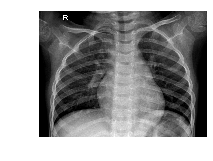

In [0]:
img = open_image(path/'val'/'NORMAL'/'NORMAL2-IM-1440-0001.jpeg')
print(img.data.shape)
img.show()

In [0]:
tfms = get_transforms()


In [0]:
np.random.seed(7)
data = ImageDataBunch.from_folder(path, 
                                  valid='val',
                                  valid_pct=0.2,
                                  size=256, bs=bs,
                                  ds_tfms=tfms).normalize(imagenet_stats)

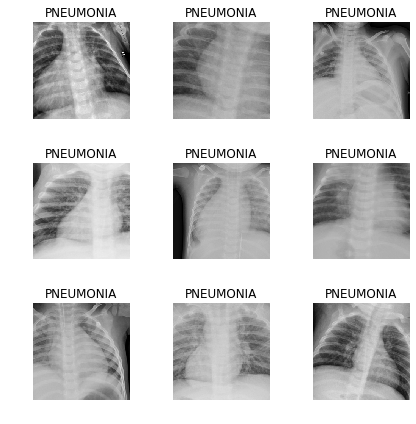

In [0]:
data.show_batch(3, figsize=(6,6))


In [0]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)


(['NORMAL', 'PNEUMONIA'], 2, 9370, 2342)

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate, model_dir="/tmp/model/")


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 82899605.88it/s]


In [0]:
learn.fit_one_cycle(4)


epoch,train_loss,valid_loss,error_rate,time
0,0.253484,0.184193,0.061486,08:56
1,0.151641,0.103187,0.036721,09:00
2,0.117196,0.102879,0.038002,08:55
3,0.102082,0.092973,0.032878,09:10


In [0]:
learn.save('stage-1')


In [0]:
learn.unfreeze()



In [0]:
learn.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


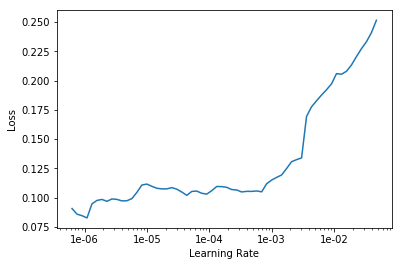

In [0]:
learn.recorder.plot()


In [0]:
learn.save('stage-2')


In [0]:
interp = ClassificationInterpretation.from_learner(learn)


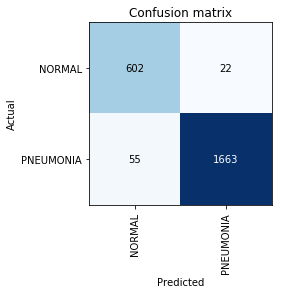

In [0]:
interp.plot_confusion_matrix()


In [0]:
CM = interp.confusion_matrix()
# Calculate Precision and Recall
tn, fp, fn, tp = CM.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.97
Precision of the model is 0.99


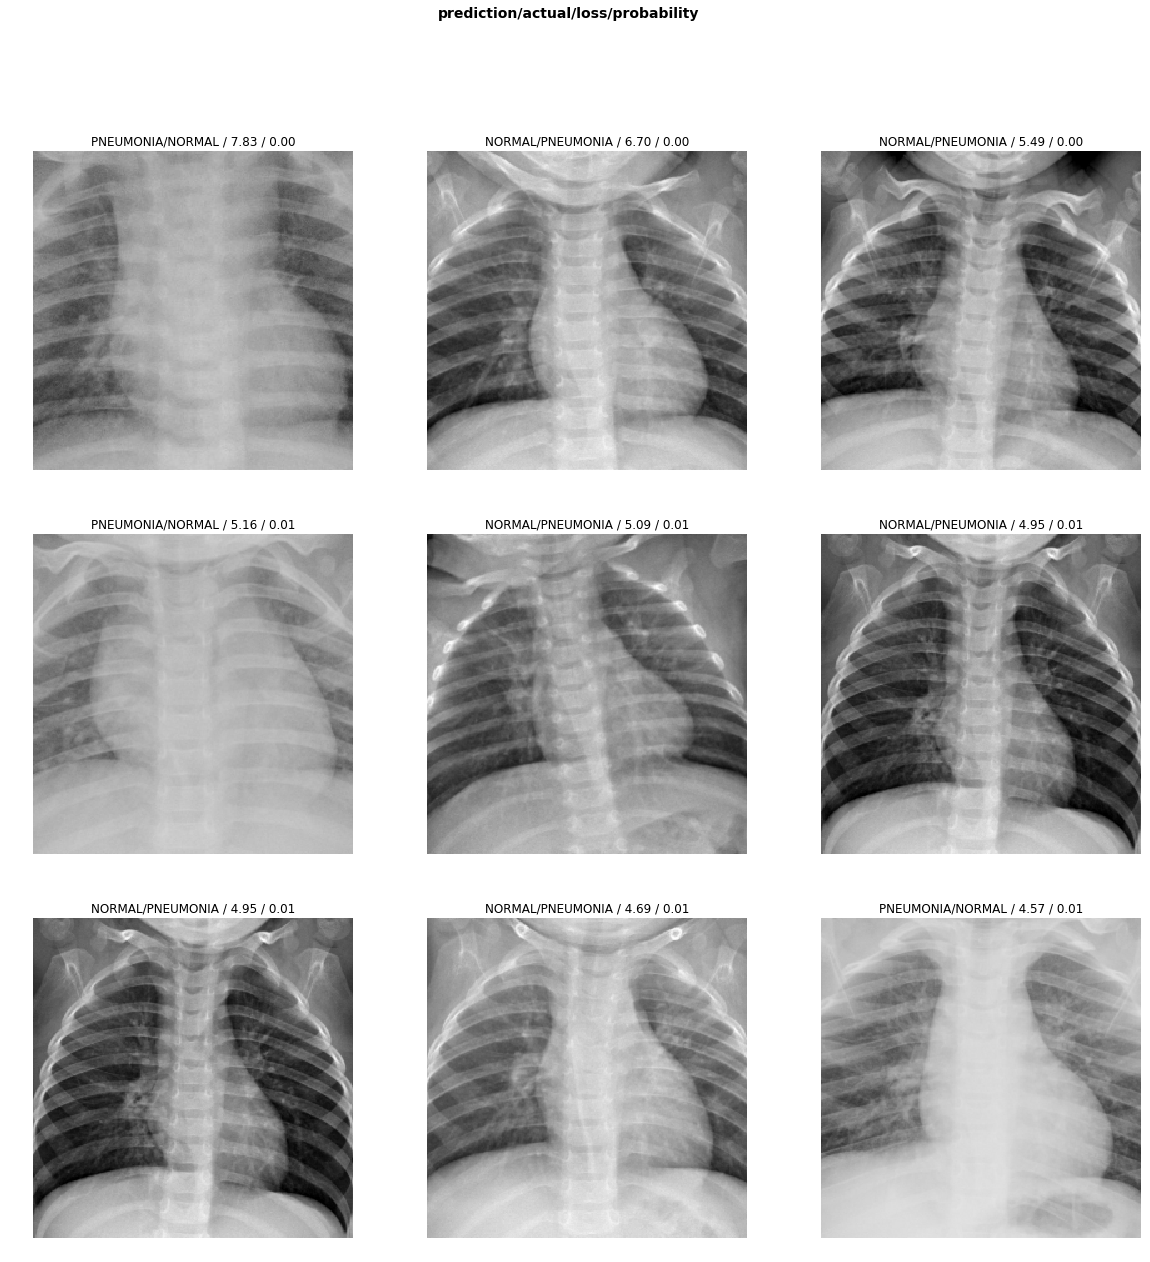

In [0]:
interp.plot_top_losses(9, figsize=(20,20))


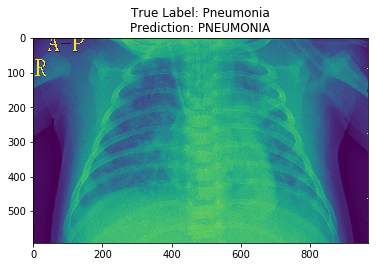

In [0]:
#@title Enter Filepath Here:
filename = "/content/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg" #@param {type:"string"}
predicton, tensor , prob = learn.predict(open_image(filename))
actual="Normal" if "NORMAL" in filename else "Pneumonia" 

img=mpimg.imread(filename)
title_text = ("%s%s%s%s%s"%("True Label: ", actual, "\n", "Prediction: ", predicton))
plt.title(title_text)
imgplot=plt.imshow(img)

